In [106]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

## Get Firebrowse RNA files

In [107]:
pheno=pd.read_csv("../data/phenotype.mapping.csv",header=None)
pheno.head()

,0,1
0,ACE,antigen present
1,ACTR10,antigen present
2,ACTR1A,antigen present
3,ACTR1B,antigen present
4,AP1B1,antigen present


In [108]:
def filter_zeros(df,threshold):
    '''
    inputs:
    df: dataframe of rna values
    threshold: % of zero values by which to exclude phenotypes
    
    output:
    dataframe with rna values < threshold of zero values
    '''
    
    keep=[]
    remove=[]
    
    for x in df.columns:
        if len(df[df[x]==0])>threshold*len(df):
            remove.append(x)
        else:
            keep.append(x)
    
    print("{} phenotypes with > {} zeroes were removed".format(len(remove),threshold))
    return(df[keep])

In [109]:
def filter_genotyped(df,fam):
    #get genotyped patients
    geno=pd.read_csv(fam,header=None,sep=" ")[0].tolist()
    df=df[df.index.isin(geno)]
    df=df.reset_index()
    df=df.rename(columns={"index":"FID"})
    return(df)

In [110]:
def get_firebrowse(direct,sample_type,phenos):
    #get cancer types
    cancer="GBM OV LUAD LUSC PRAD BLCA TGCT ESCA PAAD KIRP CESC LIHC SARC BRCA MESO CHOL KIRC UCEC COAD READ STAD HNSC SKCM THCA LGG KICH UCS ACC PCPG UVM"
    cancer=cancer.split(" ")
    
    dirs=[x for x in os.listdir(direct) if "tar.gz" not in x]
    dirs=[x for x in dirs if x.split("_")[1].split(".Merge")[0] in cancer]
    
    files=[]
    for x in dirs:
        files.append(x+"/"+[x for x in os.listdir(direct+x) if "rnaseqv2" in x][0])
    
    rna=pd.read_csv(direct+file[0],delimiter="\t")

    for x in files[1:]:
        df=pd.read_csv(direct+x,delimiter="\t")
        rna=pd.merge(rna,df,on="Hybridization REF")
        
    rna=rna.set_index("Hybridization REF")
    rna=rna.T
    rna.columns=[x.split("|")[0] for x in rna.columns]
    
    rna["code"]=rna.index.str.split("-").str[3]
    rna.index=rna.index.str[0:12]
    
    cols=[x for x in rna.columns if x!="?"]
    rna=rna[cols]
    
    rna.columns=[x.replace("-",".") for x in rna.columns]
    
    #convert aliases
    mp_ids={"CMC2":"C16orf61","ADGRE5":"CD97","SPRYD7":"C13orf1","JCHAIN":"IGJ","CTSL":"CTSL1","CTSV":"CTSL2","TEX30":"C13orf27","CENPU":"MLF1IP","CMSS1":"C3orf26","FAM216A":"C12orf24","HACD2":"PTPLB"}
    mp_ids= {v: k for k, v in mp_ids.items()}
    
    rna=rna.rename(columns=mp_ids)
    
    if sample_type == "tumor":
        rna=rna[rna["code"].str.contains("01")]
        print(rna["code"].value_counts())
        
    if sample_type=="normal":
        rna=rna[rna["code"].str.startswith("1")]
        print(rna["code"].value_counts())
        
    del rna["gene_id"]
    del rna["code"]

    rna = rna.apply(pd.to_numeric,errors="coerce")
    rna=rna.groupby(rna.index).mean()
        
    final_genes=[x for x in set(phenos) if x in rna.columns]
    rna=rna[final_genes]
        
    return(rna)


In [111]:
rna=get_firebrowse("/cellar/users/mpagadal/Data/resources/tcga/firebrowse-rsem/","tumor",pheno[0].tolist())

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47

01A    9278
01B     148
01C       6
01R       1
Name: code, dtype: int64


In [112]:
rna=filter_zeros(rna,0.1)

39 phenotypes with > 0.1 zeroes were removed


In [113]:
rna=rna.reset_index().rename(columns={"index":"FID"})

In [114]:
print(rna.shape)
rna.head()

(9127, 722)


,FID,KIF3A,HLA.A,CMC2,IMP4,ALOX5AP,AP3B1,COL8A1,FCGR1B,BTK,...,PTPRC,MS4A1,ATG5,PLAT,GGH,POLR3K,SH2D1A,GZMH,IL1A,SLC7A7
0,TCGA-02-0047,743.500007,9169.435400,252.680026,476.000032,1079.000090,928.500014,360.000009,171.500010,215.500006,...,860.000012,0.0,615.000012,1395.000028,334.500015,175.500016,5.5,1.000000,18.000000,384.500011
1,TCGA-02-0055,253.000002,46188.911302,598.065041,736.500032,3756.000205,902.000009,1534.500025,371.000016,302.500006,...,1254.000011,1.0,1163.500015,5673.000072,2223.000064,243.500015,13.0,15.000001,35.500000,848.500016
2,TCGA-02-2483,537.500004,22839.740557,801.445047,844.500032,671.000032,832.000007,12.500000,313.500011,199.500004,...,433.000003,3.0,943.500010,1791.500020,2581.000065,336.000018,7.5,16.000001,8.000000,562.500010
3,TCGA-02-2485,784.000007,11909.240396,412.020032,858.500044,322.500020,995.500012,36.000001,126.500006,130.500004,...,280.000003,1.5,854.000013,2777.500042,1184.000040,407.000029,8.0,23.000002,12.500000,411.000009
4,TCGA-02-2486,380.500003,35666.791077,313.800023,691.500032,4651.000270,940.000010,261.000005,721.500031,666.500012,...,1164.500010,2.0,1069.000014,389.500005,265.000008,207.000014,19.0,35.500002,43.000001,1115.000023


In [115]:
print(rna.shape)

(9127, 722)


## CIBERSORTx

In [116]:
ciber=pd.read_csv("/cellar/users/mpagadal/Data/cibersort/cibersortx-results/tcga/firebrowse_cibersortx_compiled_allsig.tsv",delimiter="\t")
ciber.columns=[x.replace(" ",".") for x in ciber.columns]
ciber=ciber.rename(columns={"Mixture":"FID"})
ciber=ciber.set_index("FID")

In [117]:
ciber=filter_zeros(ciber,0.1)

50 phenotypes with > 0.1 zeroes were removed


## Immune Landscape Values

In [118]:
landscape=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/downloaded_phenos/pheno-immune-landscape-comp",delimiter="\t")
landscape=landscape.replace(-9, np.nan)
del landscape["IID"]
landscape.head()

,FID,Proliferation,Wound.Healing,Macrophage.Regulation,Lymphocyte.Infiltration.Signature.Score,IFN.gamma.Response,TGF.beta.Response
0,TCGA-01-0639,NaN,NaN,NaN,NaN,NaN,NaN
1,TCGA-02-0007,NaN,NaN,NaN,NaN,NaN,NaN
2,TCGA-02-0011,NaN,NaN,NaN,NaN,NaN,NaN
3,TCGA-02-0023,NaN,NaN,NaN,NaN,NaN,NaN
4,TCGA-02-0025,NaN,NaN,NaN,NaN,NaN,NaN


## Combine the phenotypes

In [119]:
total=pd.merge(rna,landscape,on=["FID"],how="outer")
total=pd.merge(total, ciber,on=["FID"],how="outer")
total=total.set_index("FID")

In [120]:
print(total.shape)
total.head()

(11189, 738)


,KIF3A,HLA.A,CMC2,IMP4,ALOX5AP,AP3B1,COL8A1,FCGR1B,BTK,PRF1,...,HNSCC.Endothelial,NSCLC.Fig2ab.B.cells,dice.CD8_STIM,dice.M2,dice.TH1,melanoma.CAF,melanoma.Macrophages,LM22.T.cells.CD4.memory.resting,LM22.T.cells.follicular.helper,LM22.Macrophages.M2
FID,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,743.500007,9169.435400,252.680026,476.000032,1079.000090,928.500014,360.000009,171.500010,215.500006,18.500000,...,0.321709,0.889466,0.035240,0.404353,0.130165,0.336128,0.246583,0.220084,0.021803,0.297373
TCGA-02-0055,253.000002,46188.911302,598.065041,736.500032,3756.000205,902.000009,1534.500025,371.000016,302.500006,126.500002,...,0.030928,0.872109,0.191763,0.343408,0.064467,0.798965,0.181196,0.253631,0.106656,0.227131
TCGA-02-2483,537.500004,22839.740557,801.445047,844.500032,671.000032,832.000007,12.500000,313.500011,199.500004,222.000003,...,0.401449,0.887999,0.057997,0.397118,0.000000,0.296410,0.270757,0.253210,0.021483,0.332835
TCGA-02-2485,784.000007,11909.240396,412.020032,858.500044,322.500020,995.500012,36.000001,126.500006,130.500004,78.500002,...,0.582310,0.843292,0.032920,0.247421,0.180549,0.262526,0.165664,0.040852,0.067072,0.381885
TCGA-02-2486,380.500003,35666.791077,313.800023,691.500032,4651.000270,940.000010,261.000005,721.500031,666.500012,58.000001,...,0.140313,0.898673,0.060488,0.403104,0.158960,0.272828,0.350220,0.097500,0.026355,0.564514


## Filter for genotyped individuals

In [121]:
tcga_df=filter_genotyped(total,"/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam")

## Submit cancer-type specific

In [122]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_df["cancer"]=tcga_df["FID"].map(mp)

In [123]:
pheno_dir="/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/firebrowse/tumor/"

In [124]:
for x in tcga_df["cancer"].unique():
    try:
        tumor=tcga_df[tcga_df["cancer"]==x]
        del tumor["cancer"]
        tumor.to_csv(pheno_dir+"pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        pass

In [128]:
compiled=pd.DataFrame()
for x in tcga_df["cancer"].unique().tolist():
    try:
        df=pd.read_csv(pheno_dir+"pheno_"+x+".rank.csv",delimiter="\t")
        df["cancer"]=x
        compiled=compiled.append(df)
    except:
        pass

### Confirm rank norm by cancer

Text(0.5, 1.0, 'FGR')

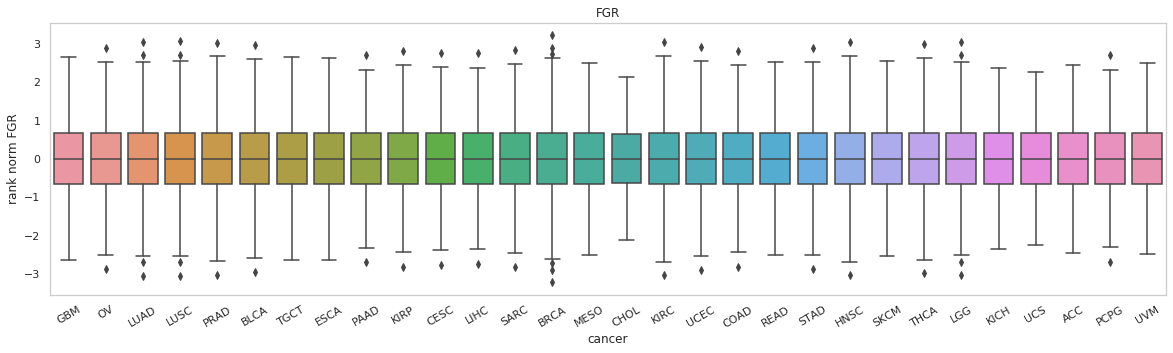

In [129]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

In [130]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [132]:
compiled.to_csv(pheno_dir+"pheno_all_zcancer",index=None,sep="\t")

In [131]:
print(compiled.shape)

(8195, 740)


## Get normal phenotype

In [93]:
rna=get_firebrowse("/cellar/users/mpagadal/Data/resources/tcga/firebrowse-rsem/","normal",pheno[0].tolist())

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47

11A    702
11B     17
11C      1
Name: code, dtype: int64


In [95]:
rna=filter_zeros(rna,0.1)

33 phenotypes with > 0.1 zeroes were removed


In [96]:
print(rna.shape)

(710, 727)


In [97]:
tcga_df=filter_genotyped(rna,"/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam")

In [98]:
tcga_df.head()

,FID,KIF3A,HLA.A,CMC2,IMP4,ALOX5AP,AP3B1,COL8A1,FCGR1B,BTK,...,PTPRC,MS4A1,ATG5,PLAT,GGH,POLR3K,SH2D1A,GZMH,BLK,SLC7A7
0,TCGA-22-4593,270.4881,37536.3593,235.7292,748.9641,5584.0358,1537.3474,1592.3267,529.3060,763.7463,...,4668.5775,28.5270,816.3916,1479.2560,245.8511,346.7330,100.8819,243.7764,15.0415,2768.1589
1,TCGA-22-4609,384.4274,23804.4204,210.8415,379.1899,1451.4665,1077.5140,1094.6229,162.3603,456.7039,...,3278.9804,192.0391,742.3184,736.3827,139.6648,215.4330,127.7933,282.4721,82.0531,1005.5866
2,TCGA-22-5471,370.7192,24268.7329,193.2320,482.4486,4025.2568,1177.6541,1426.7979,272.2603,880.5651,...,2735.4452,7.7055,792.8082,750.8562,218.7500,306.5068,53.9384,68.9212,2.1404,2911.3870
3,TCGA-22-5472,411.3204,30530.3227,191.0731,503.5792,3777.9972,1361.3296,2143.4791,274.7262,871.3330,...,4856.9124,9.7384,701.6793,1197.8265,224.7526,254.4805,68.4253,202.7130,4.6129,2174.4883
4,TCGA-22-5478,323.3794,41666.8808,167.1526,470.2453,4636.0197,1226.8103,1665.4862,357.6938,958.6085,...,4557.5083,171.0232,692.6029,333.2620,145.4933,206.1612,82.0802,270.3979,48.5893,2785.5100


### Submit cancer-specific phenos for rank normalization

In [99]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
tcga_df["cancer"]=tcga_df["FID"].map(mp)

In [100]:
pheno_dir="/cellar/users/mpagadal/Data/projects/germline-immune/discovery/phenotypes/processed_phenos/firebrowse/normal/"

In [101]:
for x in tcga_df["cancer"].unique():
    try:
        nml=tcga_df[tcga_df["cancer"]==x]
        del nml["cancer"]
        nml.to_csv(pheno_dir+"pheno_"+x+".unnorm.csv",index=None,sep="\t")
    except:
        pass

In [102]:
compiled=pd.DataFrame()
for x in tcga_df["cancer"].unique().tolist():
    try:
        df=pd.read_csv(pheno_dir+"pheno_"+x+".rank.csv",delimiter="\t")
        df["cancer"]=x
        compiled=compiled.append(df)
    except:
        pass

### Confirm rank norm

Text(0.5, 1.0, 'FGR')

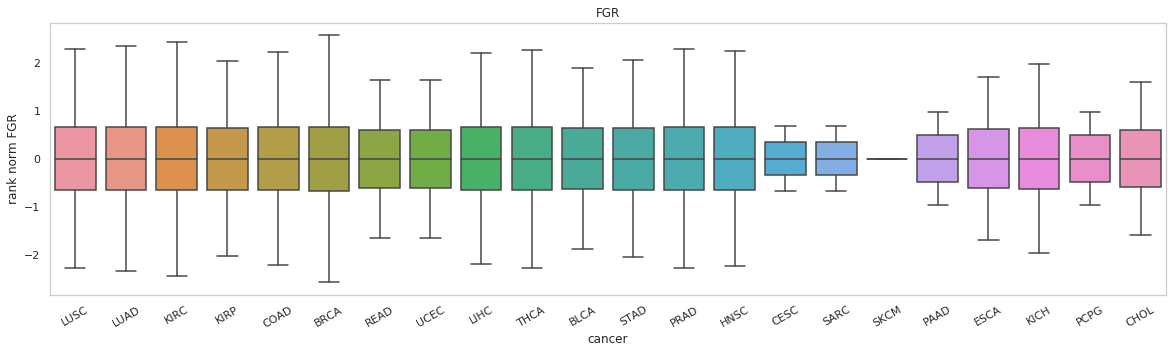

In [103]:
x="FGR"
#plot rna expression by cancer type
sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(20,5))
sns.set_style("whitegrid", {'axes.grid' : False})
ax = sns.boxplot(x="cancer", y=x, data=compiled)
ax.set(xlabel="cancer", ylabel='rank norm FGR')
plt.xticks(rotation=30)
plt.title(x)

In [104]:
del compiled["cancer"]
compiled["IID"]=compiled["FID"]
cols=["FID","IID"]+compiled.columns.tolist()[1:-1]
compiled=compiled[cols]
compiled.columns=[x.replace("-",".") for x in compiled.columns]
compiled=compiled.fillna(-9)

In [105]:
compiled.to_csv(pheno_dir+"pheno_all_zcancer",index=None,sep="\t")

## Get Pearson correlation

In [61]:
del pheno["IID"]

In [62]:
pheno=pheno.replace(-9, np.nan)

In [63]:
pheno_corr=pheno.corr(method="pearson")

In [64]:
pheno_corr.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/immune-phenotype-pearson/firebrowse.immune.phenotypes.pearson.csv")